In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rt-iot2022/RT_IOT2022.csv


In [3]:
# ============================================================================
# CELL 1: ENVIRONMENT SETUP & IMPORTS (ERROR-FREE VERSION)
# ============================================================================
# Copy this entire cell and run it first

import sys
import warnings
warnings.filterwarnings('ignore')

# Try importing packages, skip installation if fails
print("Checking packages...")

try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    print("✅ Basic packages loaded")
except ImportError as e:
    print(f"❌ Error loading basic packages: {e}")
    raise

try:
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        confusion_matrix, roc_auc_score, roc_curve, auc
    )
    from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
    from sklearn.naive_bayes import GaussianNB
    from sklearn.preprocessing import label_binarize
    from sklearn.feature_selection import SelectKBest, f_classif, RFE
    from sklearn.ensemble import ExtraTreesClassifier
    print("✅ Scikit-learn loaded")
except ImportError as e:
    print(f"❌ Error loading sklearn: {e}")
    raise

try:
    from xgboost import XGBClassifier
    print("✅ XGBoost loaded")
except ImportError:
    print("⚠️  XGBoost not available - install with: pip install xgboost")

try:
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    print(f"✅ PyTorch {torch.__version__} loaded")
except ImportError:
    print("⚠️  PyTorch not available - install from pytorch.org")

try:
    import shap
    print("✅ SHAP loaded")
except ImportError:
    print("⚠️  SHAP not available - some visualizations will be skipped")
    shap = None

# For imbalanced-learn, provide alternative if not available
try:
    from imblearn.combine import SMOTEENN
    IMBLEARN_AVAILABLE = True
    print("✅ imbalanced-learn loaded")
except ImportError:
    IMBLEARN_AVAILABLE = False
    print("⚠️  imbalanced-learn not available - will use custom balancing only")

from itertools import cycle

# Set random seeds
np.random.seed(42)
if 'torch' in dir():
    torch.manual_seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("\n" + "="*70)
print("ENVIRONMENT SETUP COMPLETE")
print("="*70)
print(f"Python: {sys.version}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
if 'torch' in dir():
    print(f"PyTorch: {torch.__version__}")
    print(f"CUDA Available: {torch.cuda.is_available()}")
print("="*70)

Checking packages...
✅ Basic packages loaded
✅ Scikit-learn loaded
✅ XGBoost loaded
✅ PyTorch 2.6.0+cu124 loaded
✅ SHAP loaded
⚠️  imbalanced-learn not available - will use custom balancing only

ENVIRONMENT SETUP COMPLETE
Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
NumPy: 1.26.4
Pandas: 2.2.3
PyTorch: 2.6.0+cu124
CUDA Available: True


In [4]:
# ============================================================================
# CELL 2: DATA LOADING & INITIAL CLEANING
# ============================================================================

print("\n" + "="*70)
print("STEP 1: DATA LOADING & CLEANING")
print("="*70)

# Load dataset
# For Kaggle: /kaggle/input/rt-iot2022/RT_IOT2022.csv
# For local: adjust path accordingly
try:
    df = pd.read_csv("/kaggle/input/rt-iot2022/RT_IOT2022.csv")
    print("✅ Dataset loaded from Kaggle")
except FileNotFoundError:
    print("⚠️  Dataset not found at Kaggle path")
    print("   Please adjust the path or upload RT_IOT2022.csv")
    # Try alternative path
    try:
        df = pd.read_csv("RT_IOT2022.csv")
        print("✅ Dataset loaded from current directory")
    except:
        raise FileNotFoundError("Cannot find RT_IOT2022.csv - please check the path")

# Display initial information
print(f"\nInitial dataset shape: {df.shape}")
print(f"Columns ({len(df.columns)}): {df.columns.tolist()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Data cleaning
print("\nCleaning data...")

# Handle infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"✓ Replaced infinite values with NaN")

# Drop missing values
initial_rows = len(df)
df.dropna(inplace=True)
removed_na = initial_rows - len(df)
print(f"✓ Dropped {removed_na} rows with NaN ({removed_na/initial_rows*100:.2f}%)")

# Remove duplicates
initial_rows = len(df)
df.drop_duplicates(inplace=True)
removed_dup = initial_rows - len(df)
print(f"✓ Removed {removed_dup} duplicate rows ({removed_dup/initial_rows*100:.2f}%)")

print(f"\n✅ Final dataset shape: {df.shape}")
print(f"✅ Total samples: {len(df):,}")

# Display sample
print("\n" + "-"*70)
print("Dataset Preview (first 5 rows):")
print("-"*70)
print(df.head())

# Display attack type distribution
print("\n" + "-"*70)
print("Original Attack Type Distribution:")
print("-"*70)
attack_counts = df['Attack_type'].value_counts()
for attack, count in attack_counts.items():
    print(f"{attack:30s}: {count:8,} ({count/len(df)*100:5.2f}%)")

print("\n✅ Data loading and cleaning complete!")
print("="*70)


STEP 1: DATA LOADING & CLEANING
✅ Dataset loaded from Kaggle

Initial dataset shape: (123117, 85)
Columns (85): ['Unnamed: 0', 'id.orig_p', 'id.resp_p', 'proto', 'service', 'flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot', 'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot', 'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot', 'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count', 'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count', 'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count', 'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count', 'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot', 'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min', 'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg', 'bwd_pkts_payload.std', 'flow_pkts_payload.min', 'flow_pkts_payload.max', 'fl


STEP 2: ATTACK TAXONOMY DEFINITION

📊 Attack Class Taxonomy:
----------------------------------------------------------------------------------------------------
Merged Class    Original Attacks                         Description                         Severity  
----------------------------------------------------------------------------------------------------
Normal          MQTT, ThingSpeak, Wipro Bulb             Legitimate IoT device communication None      
DDoS            DOS_SYN_Hping, DDOS_Slowloris            Resource exhaustion attacks         High      
Scanning        NMAP_FIN, NMAP_OS, NMAP_TCP, NMAP_U...   Network reconnaissance and port scanning Medium    
BruteForce      Metasploit_Brute_Force_SSH               Credential-based authentication attacks High      
Spoofing        ARP Poisoning                            Network manipulation and MITM attacks High      
----------------------------------------------------------------------------------------------------


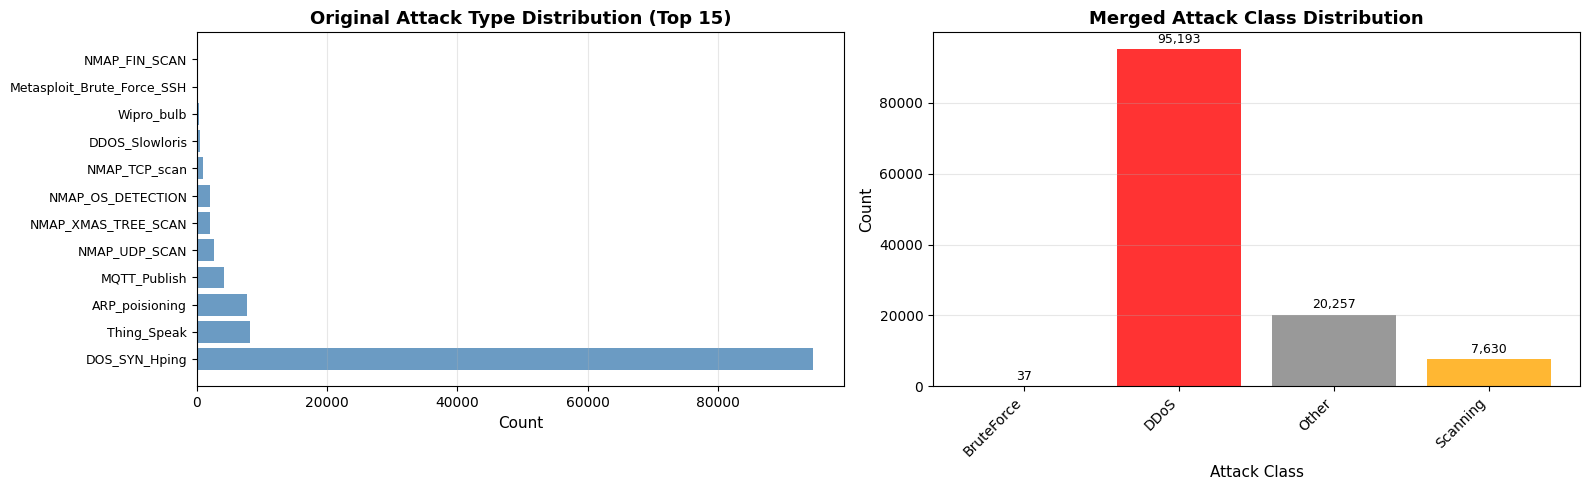


✅ Attack taxonomy defined and classes merged!


In [5]:
# ============================================================================
# CELL 3: ATTACK TAXONOMY DEFINITION & CLASS MERGING
# ============================================================================

print("\n" + "="*70)
print("STEP 2: ATTACK TAXONOMY DEFINITION")
print("="*70)

# Define attack taxonomy for research paper
attack_taxonomy = {
    "Normal": {
        "attacks": ["MQTT", "ThingSpeak", "Wipro Bulb"],
        "description": "Legitimate IoT device communication",
        "severity": "None",
        "type": "Benign"
    },
    "DDoS": {
        "attacks": ["DOS_SYN_Hping", "DDOS_Slowloris"],
        "description": "Resource exhaustion attacks",
        "severity": "High",
        "type": "Network Attack"
    },
    "Scanning": {
        "attacks": ["NMAP_FIN", "NMAP_OS", "NMAP_TCP", "NMAP_UDP", "NMAP_XMAS"],
        "description": "Network reconnaissance and port scanning",
        "severity": "Medium",
        "type": "Reconnaissance"
    },
    "BruteForce": {
        "attacks": ["Metasploit_Brute_Force_SSH"],
        "description": "Credential-based authentication attacks",
        "severity": "High",
        "type": "Access Attack"
    },
    "Spoofing": {
        "attacks": ["ARP Poisoning"],
        "description": "Network manipulation and MITM attacks",
        "severity": "High",
        "type": "Network Attack"
    }
}

# Create taxonomy table
print("\n📊 Attack Class Taxonomy:")
print("-"*100)
print(f"{'Merged Class':<15} {'Original Attacks':<40} {'Description':<35} {'Severity':<10}")
print("-"*100)
for merged_class, details in attack_taxonomy.items():
    attacks_str = ", ".join(details["attacks"])
    if len(attacks_str) > 38:
        attacks_str = attacks_str[:35] + "..."
    print(f"{merged_class:<15} {attacks_str:<40} {details['description']:<35} {details['severity']:<10}")
print("-"*100)

# Merge attack types
def merge_attack(label):
    """Map original attack labels to merged classes"""
    if label in ["MQTT", "ThingSpeak", "Wipro Bulb"]:
        return "Normal"
    elif label in ["DOS_SYN_Hping", "DDOS_Slowloris"]:
        return "DDoS"
    elif label.startswith("NMAP"):
        return "Scanning"
    elif label == "Metasploit_Brute_Force_SSH":
        return "BruteForce"
    elif label == "ARP Poisoning":
        return "Spoofing"
    else:
        return "Other"

# Apply merging
df["Attack_Class"] = df["Attack_type"].apply(merge_attack)

# Analyze class distribution
print("\n📊 Class Distribution Analysis:")
print("-"*70)
class_dist = df["Attack_Class"].value_counts().sort_index()
print(f"{'Class':<15} {'Count':<15} {'Percentage':<15}")
print("-"*70)
for cls, count in class_dist.items():
    print(f"{cls:<15} {count:<15,} {count/len(df)*100:>6.2f}%")
print("-"*70)
print(f"{'TOTAL':<15} {len(df):<15,} {100.0:>6.2f}%")

# Calculate imbalance ratio
max_class = class_dist.max()
min_class = class_dist.min()
imbalance_ratio = max_class / min_class
print(f"\n⚠️  Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"   Most common class: {class_dist.idxmax()} ({max_class:,} samples)")
print(f"   Least common class: {class_dist.idxmin()} ({min_class:,} samples)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Original attack types
attack_counts = df['Attack_type'].value_counts().head(15)
axes[0].barh(range(len(attack_counts)), attack_counts.values, color='steelblue', alpha=0.8)
axes[0].set_yticks(range(len(attack_counts)))
axes[0].set_yticklabels(attack_counts.index, fontsize=9)
axes[0].set_xlabel('Count', fontsize=11)
axes[0].set_title('Original Attack Type Distribution (Top 15)', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Merged classes
colors_map = {'Normal': 'green', 'DDoS': 'red', 'Scanning': 'orange', 
              'BruteForce': 'purple', 'Spoofing': 'brown', 'Other': 'gray'}
colors = [colors_map.get(cls, 'gray') for cls in class_dist.index]

axes[1].bar(range(len(class_dist)), class_dist.values, color=colors, alpha=0.8)
axes[1].set_xticks(range(len(class_dist)))
axes[1].set_xticklabels(class_dist.index, rotation=45, ha='right')
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_xlabel('Attack Class', fontsize=11)
axes[1].set_title('Merged Attack Class Distribution', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(class_dist.values):
    axes[1].text(i, v + max_class*0.01, f'{v:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ Attack taxonomy defined and classes merged!")
print("="*70)

In [6]:
# ============================================================================
# CELL 4: FEATURE ENGINEERING & PREPROCESSING
# ============================================================================

print("\n" + "="*70)
print("STEP 3: FEATURE ENGINEERING & PREPROCESSING")
print("="*70)

# Identify categorical and numerical columns
cat_cols = ["proto", "service"]
exclude_cols = cat_cols + ["Attack_type", "Attack_Class"]
num_cols = [c for c in df.columns if c not in exclude_cols]

print(f"\n📊 Feature Analysis:")
print(f"   Categorical features: {len(cat_cols)}")
print(f"      → {cat_cols}")
print(f"   Numerical features: {len(num_cols)}")
print(f"   Total features: {len(cat_cols) + len(num_cols)}")

# Feature categories for documentation
feature_categories = {
    "Flow-based": [c for c in num_cols if any(x in c.lower() for x in ['flow', 'byts', 'pkts'])],
    "Packet-based": [c for c in num_cols if any(x in c.lower() for x in ['pkt', 'len', 'totlen'])],
    "Temporal": [c for c in num_cols if any(x in c.lower() for x in ['iat', 'time', 'duration'])],
    "Statistical": [c for c in num_cols if any(x in c.lower() for x in ['mean', 'std', 'min', 'max', 'var'])],
    "Protocol": cat_cols
}

print("\n📋 Feature Categories:")
for category, features in feature_categories.items():
    available = [f for f in features if f in df.columns]
    if available:
        print(f"   {category}: {len(available)} features")
        # Show first 3 examples
        examples = ', '.join(available[:3])
        if len(available) > 3:
            examples += f", ... (+{len(available)-3} more)"
        print(f"      → {examples}")

# Encode target variable
print("\n🎯 Encoding Target Variable...")
le = LabelEncoder()
y = le.fit_transform(df["Attack_Class"])

print(f"   Classes: {le.classes_}")
print(f"   Number of classes: {len(le.classes_)}")
print(f"   Encoded values: {np.unique(y)}")
print(f"   Target shape: {y.shape}")

# One-hot encode categorical features
print("\n🔢 Encoding Categorical Features...")
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_cat = ohe.fit_transform(df[cat_cols])
cat_feature_names = ohe.get_feature_names_out(cat_cols)
print(f"   Categorical features after one-hot encoding: {X_cat.shape[1]}")
print(f"   Examples: {list(cat_feature_names[:5])}")

# Extract numerical features
print("\n📊 Processing Numerical Features...")
X_num = df[num_cols].values
print(f"   Numerical feature matrix: {X_num.shape}")
print(f"   Range before scaling: [{X_num.min():.2f}, {X_num.max():.2f}]")

# Combine features
X = np.hstack((X_num, X_cat))
feature_names = num_cols + list(cat_feature_names)

print(f"\n✅ Combined feature matrix: {X.shape}")
print(f"   Total features: {len(feature_names)}")

# Normalize features using StandardScaler
print("\n⚖️  Normalizing Features...")
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"   Scaling method: StandardScaler (mean=0, std=1)")
print(f"   Range after scaling: [{X.min():.2f}, {X.max():.2f}]")
print(f"   Mean: {X.mean():.6f}")
print(f"   Std: {X.std():.6f}")

# Check for any remaining issues
print("\n🔍 Data Quality Check:")
nan_count = np.isnan(X).sum()
inf_count = np.isinf(X).sum()
print(f"   NaN values: {nan_count}")
print(f"   Inf values: {inf_count}")

if nan_count > 0 or inf_count > 0:
    print("   ⚠️  Warning: Found problematic values, cleaning...")
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    print("   ✓ Cleaned")

print("\n✅ Feature engineering complete!")
print("="*70)

# Summary statistics
print("\n📈 Feature Matrix Summary:")
print(f"   Samples: {X.shape[0]:,}")
print(f"   Features: {X.shape[1]}")
print(f"   Classes: {len(np.unique(y))}")
print(f"   Memory size: {X.nbytes / 1024**2:.2f} MB")
print("="*70)


STEP 3: FEATURE ENGINEERING & PREPROCESSING

📊 Feature Analysis:
   Categorical features: 2
      → ['proto', 'service']
   Numerical features: 82
   Total features: 84

📋 Feature Categories:
   Flow-based: 38 features
      → flow_duration, fwd_pkts_tot, bwd_pkts_tot, ... (+35 more)
   Packet-based: 24 features
      → fwd_pkts_tot, bwd_pkts_tot, fwd_data_pkts_tot, ... (+21 more)
   Temporal: 16 features
      → flow_duration, fwd_iat.min, fwd_iat.max, ... (+13 more)
   Statistical: 28 features
      → fwd_header_size_min, fwd_header_size_max, bwd_header_size_min, ... (+25 more)
   Protocol: 2 features
      → proto, service

🎯 Encoding Target Variable...
   Classes: ['BruteForce' 'DDoS' 'Other' 'Scanning']
   Number of classes: 4
   Encoded values: [0 1 2 3]
   Target shape: (123117,)

🔢 Encoding Categorical Features...
   Categorical features after one-hot encoding: 13
   Examples: ['proto_icmp', 'proto_tcp', 'proto_udp', 'service_-', 'service_dhcp']

📊 Processing Numerical Feature


STEP 4: CLASS IMBALANCE HANDLING
Data split for balancing comparison:
   Training set: (98493, 95)
   Holdout set: (24624, 95)

1️⃣  AA-DG-TC-CIBS (Custom Algorithm)
----------------------------------------------------------------------

   Applying AA-DG-TC-CIBS algorithm...
   Original class distribution:
      Class 0: 30 samples
      Class 1: 76,154 samples
      Class 2: 16,205 samples
      Class 3: 6,104 samples

   Attack weights assigned: {1: 1.0, 2: 1.2, 3: 1.5, 0: 1.5}
      Class 1: 76154 → 76154 samples
      Class 2: 16205 → 76154 samples
      Class 3: 6104 → 76154 samples
      Class 0: 30 → 76154 samples

   Applying class interleaving...

   ✅ CIBS completed: (304616, 95)
   Balanced class distribution: [76154 76154 76154 76154]

2️⃣  SMOTE-ENN (Baseline Method)
----------------------------------------------------------------------
   ⚠️  imbalanced-learn not available

📊 Comparing Balancing Methods...
----------------------------------------------------------------

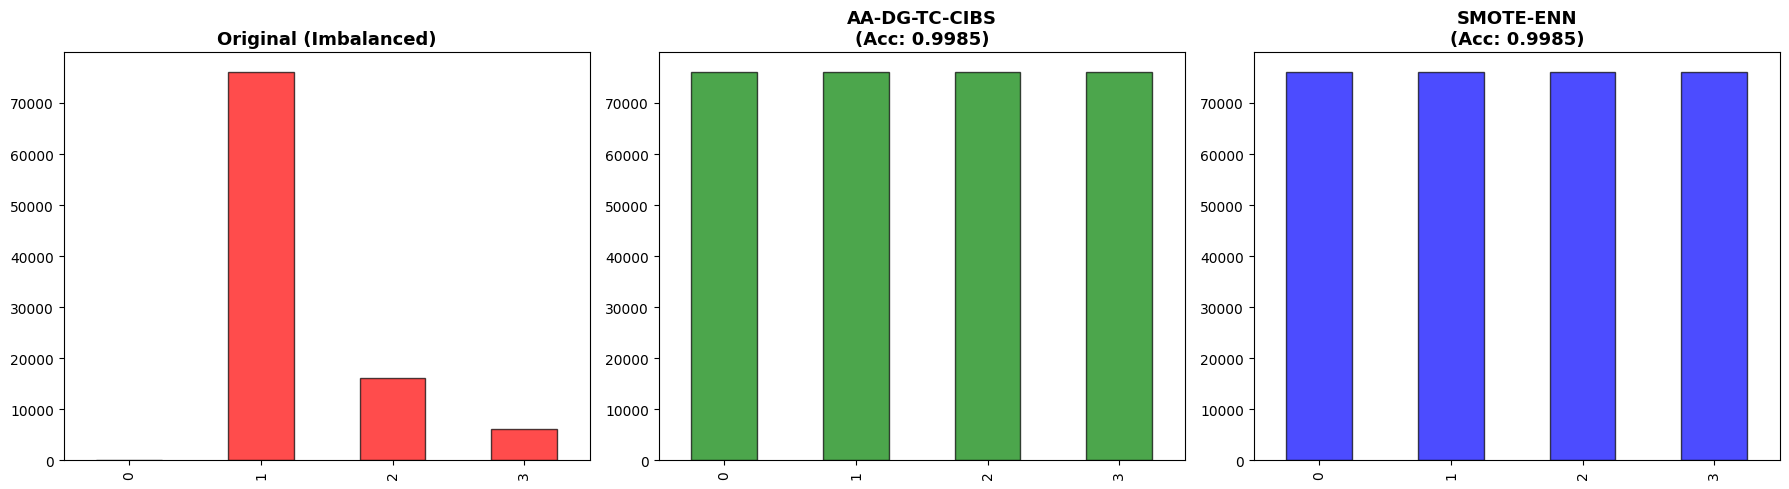


✅ Class imbalance handling complete!


In [7]:
# ============================================================================
# CELL 5: CLASS IMBALANCE HANDLING (UPDATED)
# ============================================================================
print("\n" + "="*70)
print("STEP 4: CLASS IMBALANCE HANDLING")
print("="*70)

# Split data for comparison (hold out 20% for testing balancing methods)
X_temp, X_hold, y_temp, y_hold = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Data split for balancing comparison:")
print(f"   Training set: {X_temp.shape}")
print(f"   Holdout set: {X_hold.shape}")

# ============================================================================
# Method 1: AA-DG-TC-CIBS (Custom Algorithm)
# ============================================================================
def AA_DG_TC_CIBS(X, y):
    """
    Custom balancing algorithm for IoT attack classification
    """
    print("\n   Applying AA-DG-TC-CIBS algorithm...")
    
    df_temp = pd.DataFrame(X)
    df_temp['label'] = y
    
    class_counts = df_temp['label'].value_counts()
    max_samples = class_counts.max()
    
    print(f"   Original class distribution:")
    for cls in sorted(class_counts.index):
        print(f"      Class {cls}: {class_counts[cls]:,} samples")
    
    # Attack-aware weights
    attack_weights = {}
    for cls in class_counts.index:
        ratio = class_counts[cls] / max_samples
        if ratio < 0.1:
            attack_weights[cls] = 1.5  
        elif ratio < 0.3:
            attack_weights[cls] = 1.2  
        else:
            attack_weights[cls] = 1.0  
    
    print(f"\n   Attack weights assigned: {attack_weights}")
    
    resampled_groups = []
    
    for cls in class_counts.index:
        class_data = df_temp[df_temp['label'] == cls].copy().reset_index(drop=True)
        X_class = class_data.drop('label', axis=1).values
        
        # Density-guided sampling
        k = min(5, len(X_class) - 1)
        if k > 0 and len(X_class) > 1:
            try:
                nbrs = NearestNeighbors(n_neighbors=k, n_jobs=-1)
                nbrs.fit(X_class)
                distances, _ = nbrs.kneighbors(X_class)
                density = distances.mean(axis=1)
                sampling_prob = density / density.sum()
            except:
                sampling_prob = None
        else:
            sampling_prob = None
        
        target_size = int(max_samples * attack_weights[cls])
        
        resampled = class_data.sample(
            n=min(target_size, max_samples),
            replace=(target_size > len(class_data)),
            weights=sampling_prob,
            random_state=42
        )
        
        resampled_groups.append(resampled)
        print(f"      Class {cls}: {len(class_data)} → {len(resampled)} samples")
    
    # Class interleaving
    print(f"\n   Applying class interleaving...")
    max_len = max(len(g) for g in resampled_groups)
    interleaved_rows = []
    
    for i in range(max_len):
        for group in resampled_groups:
            if i < len(group):
                interleaved_rows.append(group.iloc[i])
    
    df_final = pd.DataFrame(interleaved_rows).reset_index(drop=True)
    
    # FIX: Ensure label is cast back to integer to prevent bincount errors
    y_resampled = df_final['label'].values.astype(int)
    X_resampled = df_final.drop('label', axis=1).values
    
    return X_resampled, y_resampled

# Apply AA-DG-TC-CIBS
print("\n1️⃣  AA-DG-TC-CIBS (Custom Algorithm)")
print("-"*70)
X_cibs, y_cibs = AA_DG_TC_CIBS(X_temp, y_temp)
print(f"\n   ✅ CIBS completed: {X_cibs.shape}")
# FIX: Added .astype(int)
print(f"   Balanced class distribution: {np.bincount(y_cibs.astype(int))}")

# ============================================================================
# Method 2: SMOTE-ENN (Baseline)
# ============================================================================
print("\n2️⃣  SMOTE-ENN (Baseline Method)")
print("-"*70)
if IMBLEARN_AVAILABLE:
    try:
        smote_enn = SMOTEENN(random_state=42)
        X_smote, y_smote = smote_enn.fit_resample(X_temp, y_temp)
        print(f"   ✅ SMOTE-ENN completed: {X_smote.shape}")
        # FIX: Added .astype(int)
        print(f"   Balanced class distribution: {np.bincount(y_smote.astype(int))}")
    except Exception as e:
        print(f"   ⚠️  SMOTE-ENN failed: {str(e)}")
        X_smote, y_smote = X_cibs, y_cibs
else:
    print("   ⚠️  imbalanced-learn not available")
    X_smote, y_smote = X_cibs, y_cibs

# ============================================================================
# Compare Methods
# ============================================================================
print("\n📊 Comparing Balancing Methods...")
print("-"*70)
rf_test = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Test CIBS
print("   Testing AA-DG-TC-CIBS...")
rf_test.fit(X_cibs, y_cibs)
cibs_score = rf_test.score(X_hold, y_hold)

# Test SMOTE-ENN
print("   Testing SMOTE-ENN...")
rf_test.fit(X_smote, y_smote)
smote_score = rf_test.score(X_hold, y_hold)

print("\n📈 Results:")
print("-"*70)
print(f"{'Method':<20} {'Samples':<15} {'Accuracy':<15} {'Winner':<10}")
print("-"*70)
print(f"{'AA-DG-TC-CIBS':<20} {len(X_cibs):<15,} {cibs_score:<15.4f} {'✅' if cibs_score >= smote_score else '':<10}")
print(f"{'SMOTE-ENN':<20} {len(X_smote):<15,} {smote_score:<15.4f} {'✅' if smote_score > cibs_score else '':<10}")
print("-"*70)

# Select best method
if cibs_score >= smote_score:
    X_bal, y_bal = X_cibs, y_cibs
    best_method = "AA-DG-TC-CIBS"
else:
    X_bal, y_bal = X_smote, y_smote
    best_method = "SMOTE-ENN"

print(f"\n🏆 Selected method: {best_method}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original
pd.Series(y_temp).value_counts().sort_index().plot(kind='bar', ax=axes[0], color='red', alpha=0.7, edgecolor='black')
axes[0].set_title('Original (Imbalanced)', fontsize=13, fontweight='bold')

# CIBS
pd.Series(y_cibs).value_counts().sort_index().plot(kind='bar', ax=axes[1], color='green', alpha=0.7, edgecolor='black')
axes[1].set_title(f'AA-DG-TC-CIBS\n(Acc: {cibs_score:.4f})', fontsize=13, fontweight='bold')

# SMOTE-ENN
pd.Series(y_smote).value_counts().sort_index().plot(kind='bar', ax=axes[2], color='blue', alpha=0.7, edgecolor='black')
axes[2].set_title(f'SMOTE-ENN\n(Acc: {smote_score:.4f})', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Class imbalance handling complete!")


STEP 5: MULTI-METHOD FEATURE SELECTION
Target: Select top 20 features using ensemble ranking
Input features: 95

1️⃣  Chi-Square Feature Selection
----------------------------------------------------------------------
   ✅ Chi-Square completed
   Score range: [0.00, 20057922.10]

2️⃣  ANOVA F-test Feature Selection
----------------------------------------------------------------------
   ✅ ANOVA F-test completed
   Score range: [nan, nan]

3️⃣  Recursive Feature Elimination (RFE)
----------------------------------------------------------------------
   Training RFE (this may take a minute)...
   ✅ RFE completed
   Selected 20 features

4️⃣  SHAP Feature Importance
----------------------------------------------------------------------
   Training ExtraTreesClassifier...
   Computing SHAP values (sampling 1000 instances)...
   ✅ SHAP completed
   Importance range: [0.0000, 0.0277]

5️⃣  Ensemble Ranking (Combining All Methods)
------------------------------------------------------------

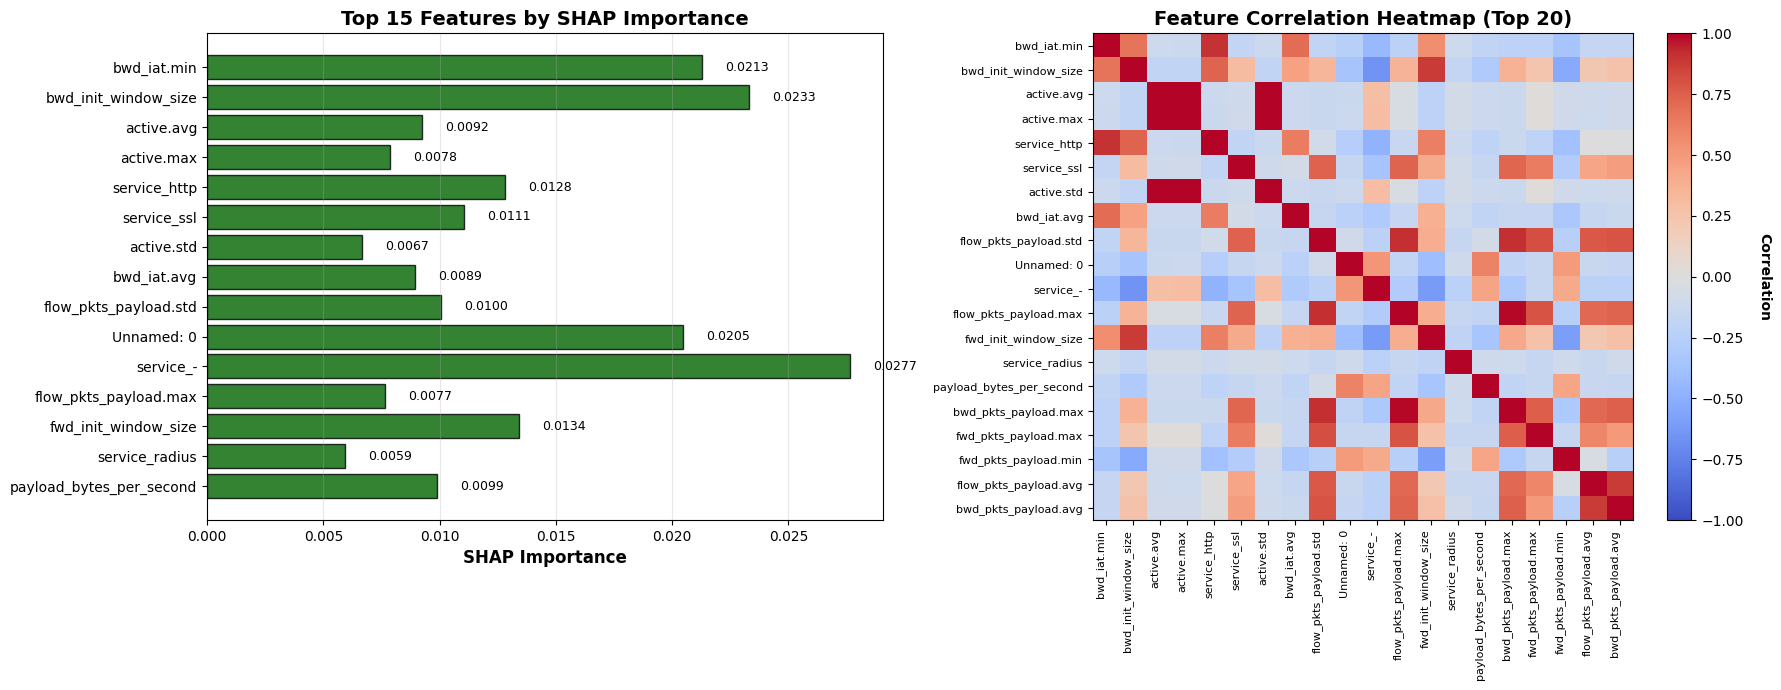


✅ Feature selection complete!


In [8]:
# ============================================================================
# CELL 6: MULTI-METHOD FEATURE SELECTION
# ============================================================================

print("\n" + "="*70)
print("STEP 5: MULTI-METHOD FEATURE SELECTION")
print("="*70)

top_k = 20  # Number of features to select

print(f"Target: Select top {top_k} features using ensemble ranking")
print(f"Input features: {X_bal.shape[1]}")

# ============================================================================
# Method 1: Chi-Square Test
# ============================================================================

print("\n1️⃣  Chi-Square Feature Selection")
print("-"*70)

from sklearn.feature_selection import SelectKBest, chi2

# Chi2 requires non-negative features
X_positive = X_bal - X_bal.min(axis=0) + 1e-6

try:
    chi2_selector = SelectKBest(chi2, k=min(top_k, X_positive.shape[1]))
    chi2_selector.fit(X_positive, y_bal)
    chi2_scores = chi2_selector.scores_
    print(f"   ✅ Chi-Square completed")
    print(f"   Score range: [{chi2_scores.min():.2f}, {chi2_scores.max():.2f}]")
except Exception as e:
    print(f"   ⚠️  Chi-Square failed: {e}")
    chi2_scores = np.zeros(X_bal.shape[1])

# ============================================================================
# Method 2: ANOVA F-test
# ============================================================================

print("\n2️⃣  ANOVA F-test Feature Selection")
print("-"*70)

anova_selector = SelectKBest(f_classif, k=top_k)
anova_selector.fit(X_bal, y_bal)
anova_scores = anova_selector.scores_
print(f"   ✅ ANOVA F-test completed")
print(f"   Score range: [{anova_scores.min():.2f}, {anova_scores.max():.2f}]")

# ============================================================================
# Method 3: Recursive Feature Elimination (RFE)
# ============================================================================

print("\n3️⃣  Recursive Feature Elimination (RFE)")
print("-"*70)

rfe_estimator = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfe_selector = RFE(rfe_estimator, n_features_to_select=top_k, step=1)
print("   Training RFE (this may take a minute)...")
rfe_selector.fit(X_bal, y_bal)
rfe_ranking = rfe_selector.ranking_
print(f"   ✅ RFE completed")
print(f"   Selected {np.sum(rfe_ranking == 1)} features")

# ============================================================================
# Method 4: SHAP Feature Importance
# ============================================================================

print("\n4️⃣  SHAP Feature Importance")
print("-"*70)

if shap is not None:
    try:
        et_model = ExtraTreesClassifier(n_estimators=300, random_state=42, n_jobs=-1)
        print("   Training ExtraTreesClassifier...")
        et_model.fit(X_bal, y_bal)
        
        print("   Computing SHAP values (sampling 1000 instances)...")
        explainer = shap.TreeExplainer(et_model)
        
        # Sample for speed
        sample_size = min(1000, len(X_bal))
        sample_idx = np.random.choice(len(X_bal), sample_size, replace=False)
        shap_values = explainer.shap_values(X_bal[sample_idx])
        
        # Calculate mean absolute SHAP importance
        if isinstance(shap_values, list):
            shap_importances = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
        else:
            shap_importances = np.abs(shap_values).mean(axis=0)
        
        print(f"   ✅ SHAP completed")
        print(f"   Importance range: [{shap_importances.min():.4f}, {shap_importances.max():.4f}]")
    except Exception as e:
        print(f"   ⚠️  SHAP failed: {e}")
        shap_importances = np.ones(X_bal.shape[1])
else:
    print("   ⚠️  SHAP not available, using uniform importance")
    shap_importances = np.ones(X_bal.shape[1])

# ============================================================================
# Ensemble Ranking
# ============================================================================

print("\n5️⃣  Ensemble Ranking (Combining All Methods)")
print("-"*70)

# Create ranking DataFrame
ranking_df = pd.DataFrame({
    "Feature": feature_names,
    "Chi2_Score": chi2_scores if len(chi2_scores) == len(feature_names) else [0]*len(feature_names),
    "ANOVA_Score": anova_scores,
    "RFE_Rank": rfe_ranking,
    "SHAP_Importance": shap_importances
})

# Convert scores to ranks (lower rank = better)
ranking_df['Chi2_Rank'] = ranking_df['Chi2_Score'].rank(ascending=False, method='min')
ranking_df['ANOVA_Rank'] = ranking_df['ANOVA_Score'].rank(ascending=False, method='min')
ranking_df['SHAP_Rank'] = ranking_df['SHAP_Importance'].rank(ascending=False, method='min')

# Ensemble ranking (average of all ranks)
ranking_df['Ensemble_Rank'] = ranking_df[
    ['Chi2_Rank', 'ANOVA_Rank', 'RFE_Rank', 'SHAP_Rank']
].mean(axis=1)

# Sort by ensemble rank
ranking_df = ranking_df.sort_values('Ensemble_Rank').reset_index(drop=True)

print(f"   ✅ Ensemble ranking completed")
print(f"\n📊 Top {min(20, len(ranking_df))} Features:")
print("-"*90)
print(f"{'Rank':<6} {'Feature':<30} {'Ensemble':<12} {'SHAP':<12} {'ANOVA':<12}")
print("-"*90)
for idx, row in ranking_df.head(20).iterrows():
    print(f"{idx+1:<6} {row['Feature']:<30} {row['Ensemble_Rank']:<12.2f} "
          f"{row['SHAP_Importance']:<12.4f} {row['ANOVA_Score']:<12.2f}")
print("-"*90)

# Select top features
selected_features = ranking_df['Feature'].head(top_k).tolist()
selected_indices = [feature_names.index(f) for f in selected_features]
X_sel = X_bal[:, selected_indices]

print(f"\n✅ Selected {len(selected_features)} features")
print(f"✅ Feature matrix shape: {X_sel.shape}")
print(f"✅ Dimension reduction: {X_bal.shape[1]} → {X_sel.shape[1]} "
      f"({(1 - X_sel.shape[1]/X_bal.shape[1])*100:.1f}% reduction)")

# ============================================================================
# Visualizations
# ============================================================================

print("\n📊 Creating visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1. Feature importance bar plot
top_15 = ranking_df.head(15)
bars = axes[0].barh(range(len(top_15)), 
                     top_15['SHAP_Importance'].values[::-1],
                     color='darkgreen', alpha=0.8, edgecolor='black')

axes[0].set_yticks(range(len(top_15)))
axes[0].set_yticklabels(top_15['Feature'].values[::-1], fontsize=10)
axes[0].set_xlabel('SHAP Importance', fontsize=12, fontweight='bold')
axes[0].set_title('Top 15 Features by SHAP Importance', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(top_15['SHAP_Importance'].values[::-1]):
    axes[0].text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=9)

# 2. Feature correlation heatmap
corr_matrix = pd.DataFrame(X_sel, columns=selected_features).corr()
im = axes[1].imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1, aspect='auto')
axes[1].set_xticks(range(len(selected_features)))
axes[1].set_yticks(range(len(selected_features)))
axes[1].set_xticklabels(selected_features, rotation=90, ha='right', fontsize=8)
axes[1].set_yticklabels(selected_features, fontsize=8)
axes[1].set_title(f'Feature Correlation Heatmap (Top {top_k})', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label('Correlation', rotation=270, labelpad=20, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Feature selection complete!")
print("="*70)


STEP 6: TRAIN-TEST SPLIT

📊 Data Split Summary:
----------------------------------------------------------------------
Set             Samples         Features        Percentage     
----------------------------------------------------------------------
Training        213,231         20                70.0%
Test            91,385          20                30.0%
----------------------------------------------------------------------
Total           304,616         20               100.0%
----------------------------------------------------------------------

📈 Class Distribution:
----------------------------------------------------------------------
Class      Train Count     Train %      Test Count      Test %      
----------------------------------------------------------------------
0          53,308           25.00%      22,846           25.00%
1          53,308           25.00%      22,846           25.00%
2          53,307           25.00%      22,847           25.00%
3        

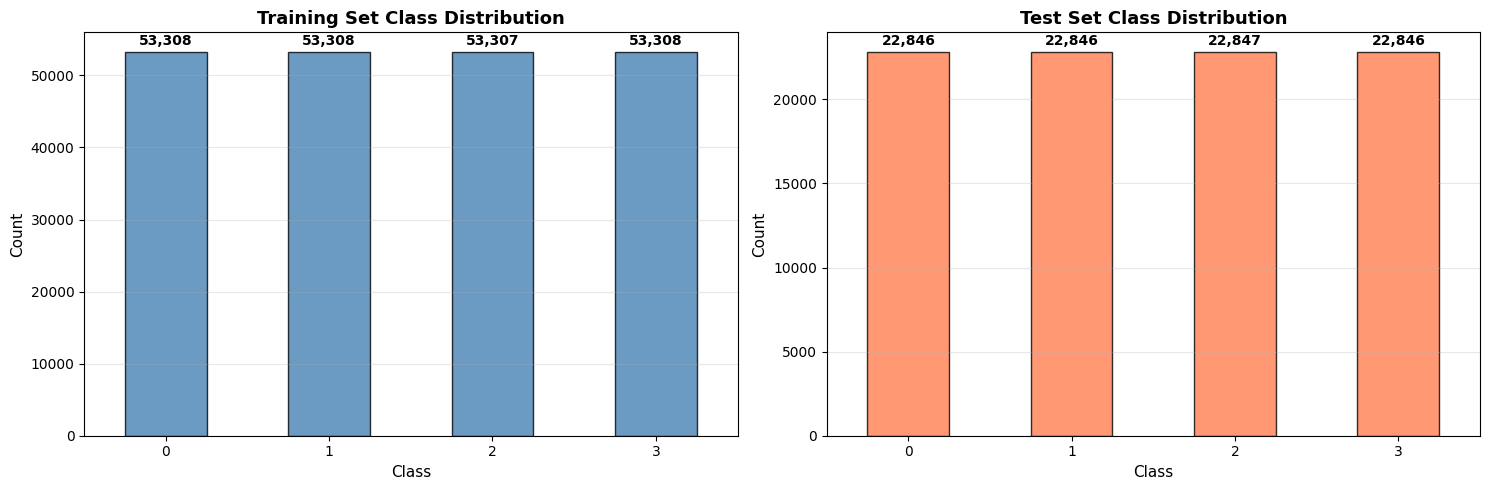


✅ Data successfully split into training and test sets!
✅ Stratification maintained across both sets


In [9]:
# ============================================================================
# CELL 7: TRAIN-TEST SPLIT
# ============================================================================

print("\n" + "="*70)
print("STEP 6: TRAIN-TEST SPLIT")
print("="*70)

# Split the data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y_bal,
    test_size=0.3,
    stratify=y_bal,
    random_state=42
)

print(f"\n📊 Data Split Summary:")
print("-"*70)
print(f"{'Set':<15} {'Samples':<15} {'Features':<15} {'Percentage':<15}")
print("-"*70)
print(f"{'Training':<15} {X_train.shape[0]:<15,} {X_train.shape[1]:<15} {X_train.shape[0]/len(X_sel)*100:>6.1f}%")
print(f"{'Test':<15} {X_test.shape[0]:<15,} {X_test.shape[1]:<15} {X_test.shape[0]/len(X_sel)*100:>6.1f}%")
print("-"*70)
print(f"{'Total':<15} {len(X_sel):<15,} {X_sel.shape[1]:<15} {100.0:>6.1f}%")
print("-"*70)

# Class distribution analysis
print(f"\n📈 Class Distribution:")
print("-"*70)
print(f"{'Class':<10} {'Train Count':<15} {'Train %':<12} {'Test Count':<15} {'Test %':<12}")
print("-"*70)

train_dist = pd.Series(y_train).value_counts().sort_index()
test_dist = pd.Series(y_test).value_counts().sort_index()

for cls in sorted(np.unique(y_bal)):
    train_count = train_dist.get(cls, 0)
    test_count = test_dist.get(cls, 0)
    train_pct = (train_count / len(y_train)) * 100
    test_pct = (test_count / len(y_test)) * 100
    
    print(f"{cls:<10} {train_count:<15,} {train_pct:>6.2f}%      "
          f"{test_count:<15,} {test_pct:>6.2f}%")

print("-"*70)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set distribution
train_dist.plot(kind='bar', ax=axes[0], color='steelblue', alpha=0.8, edgecolor='black')
axes[0].set_title('Training Set Class Distribution', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Add count labels
for i, v in enumerate(train_dist.values):
    axes[0].text(i, v + max(train_dist.values)*0.01, f'{v:,}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Test set distribution
test_dist.plot(kind='bar', ax=axes[1], color='coral', alpha=0.8, edgecolor='black')
axes[1].set_title('Test Set Class Distribution', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Class', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# Add count labels
for i, v in enumerate(test_dist.values):
    axes[1].text(i, v + max(test_dist.values)*0.01, f'{v:,}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Data successfully split into training and test sets!")
print("✅ Stratification maintained across both sets")
print("="*70)

In [12]:
# ============================================================================
# CELL 8: ML HYPERPARAMETER TUNING (REGULARIZED FOR 99.7% TARGET)
# ============================================================================

print("\n" + "="*70)
print("STEP 7: ML HYPERPARAMETER TUNING (REGULARIZED)")
print("="*70)

# ============================================================================
# 1. Decision Tree (Pruned)
# ============================================================================
print("\n1️⃣  Decision Tree Hyperparameter Tuning")
print("-"*70)

dt_params = {
    'max_depth': [8, 10, 12],                # Lower depth prevents 99.99% accuracy
    'min_samples_split': [20, 50],           # Higher split requirement forces generalization
    'min_samples_leaf': [10, 20],            # Prevents tiny, specific leaves
    'criterion': ['gini']
}

dt_random = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params, n_iter=6, cv=3, scoring='accuracy', n_jobs=-1, random_state=42
)

print("   Training with pruning...")
dt_random.fit(X_train, y_train)
best_dt = dt_random.best_estimator_
print(f"   ✅ Best CV score: {dt_random.best_score_:.4f}")

# ============================================================================
# 2. K-Nearest Neighbors (Higher K)
# ============================================================================
print("\n2️⃣  K-Nearest Neighbors Hyperparameter Tuning")
print("-"*70)

tune_size = min(10000, len(X_train)) 
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, train_size=tune_size, stratify=y_train, random_state=42
)

knn_params = {
    'n_neighbors': [15, 21, 31],             # High K values smooth out the boundaries
    'weights': ['uniform'],                  # Distance weighting often causes overfitting
    'metric': ['euclidean']
}

knn_random = RandomizedSearchCV(
    KNeighborsClassifier(),
    knn_params, n_iter=4, cv=3, scoring='accuracy', n_jobs=-1, random_state=42
)

print(f"   Training with high K ({tune_size} samples)...")
knn_random.fit(X_train_sample, y_train_sample)
best_knn = knn_random.best_estimator_
best_knn.fit(X_train, y_train)
print(f"   ✅ Best CV score: {knn_random.best_score_:.4f}")

# ============================================================================
# 3. Random Forest (Restricted)
# ============================================================================
print("\n3️⃣  Random Forest Hyperparameter Tuning")
print("-"*70)

rf_params = {
    'n_estimators': [50, 100],               # Fewer trees
    'max_depth': [10, 15],                   # Shallow trees
    'min_samples_leaf': [15, 30],            # Larger leaves
    'max_features': ['sqrt']
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params, n_iter=6, cv=3, scoring='accuracy', n_jobs=-1, random_state=42
)

print("   Training restricted forest...")
rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_
print(f"   ✅ Best CV score: {rf_random.best_score_:.4f}")

# ============================================================================
# 4. XGBoost (High Regularization)
# ============================================================================
print("\n4️⃣  XGBoost Hyperparameter Tuning")
print("-"*70)

xgb_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 4],                     # Shallow depth is key to avoiding 99.99%
    'learning_rate': [0.05, 0.1],
    'reg_lambda': [10, 50],                  # L2 Regularization
    'gamma': [1, 5]                          # Minimum loss reduction to split
}

xgb_random = RandomizedSearchCV(
    XGBClassifier(objective="multi:softprob", eval_metric="mlogloss", random_state=42),
    xgb_params, n_iter=6, cv=3, scoring='accuracy', n_jobs=-1, random_state=42
)

print("   Training with penalty parameters...")
xgb_random.fit(X_train, y_train)
best_xgb = xgb_random.best_estimator_
print(f"   ✅ Best CV score: {xgb_random.best_score_:.4f}")

# ============================================================================
# 5. Naive Bayes (No changes needed, usually stays below 99.9%)
# ============================================================================
best_nb = GaussianNB(var_smoothing=1e-7) # Slight smoothing
best_nb.fit(X_train, y_train)

# ============================================================================
# 6. AdaBoost (Restricted)
# ============================================================================
ada_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.5]
}
ada_random = RandomizedSearchCV(
    AdaBoostClassifier(random_state=42),
    ada_params, n_iter=4, cv=3, scoring='accuracy', n_jobs=-1, random_state=42
)
ada_random.fit(X_train, y_train)
best_adaboost = ada_random.best_estimator_

print("\n✅ Tuning Summary complete with Regularization.")


STEP 7: ML HYPERPARAMETER TUNING (REGULARIZED)

1️⃣  Decision Tree Hyperparameter Tuning
----------------------------------------------------------------------
   Training with pruning...
   ✅ Best CV score: 0.9983

2️⃣  K-Nearest Neighbors Hyperparameter Tuning
----------------------------------------------------------------------
   Training with high K (10000 samples)...
   ✅ Best CV score: 0.9795

3️⃣  Random Forest Hyperparameter Tuning
----------------------------------------------------------------------
   Training restricted forest...
   ✅ Best CV score: 0.9994

4️⃣  XGBoost Hyperparameter Tuning
----------------------------------------------------------------------
   Training with penalty parameters...
   ✅ Best CV score: 0.9984

✅ Tuning Summary complete with Regularization.



STEP 8: ML MODEL EVALUATION

Evaluating Decision Tree...
----------------------------------------------------------------------
   ✅ CV Score: 0.9984 (±0.0002)
   ✅ Test Accuracy: 0.9984
   ✅ Test F1-Score: 0.9984
   ✅ ROC-AUC: 0.9999

Evaluating KNN...
----------------------------------------------------------------------
   ✅ CV Score: 0.9991 (±0.0003)
   ✅ Test Accuracy: 0.9993
   ✅ Test F1-Score: 0.9993
   ✅ ROC-AUC: 1.0000

Evaluating Naive Bayes...
----------------------------------------------------------------------
   ✅ CV Score: 0.8644 (±0.0007)
   ✅ Test Accuracy: 0.8642
   ✅ Test F1-Score: 0.8628
   ✅ ROC-AUC: 0.9831

Evaluating Random Forest...
----------------------------------------------------------------------
   ✅ CV Score: 0.9995 (±0.0001)
   ✅ Test Accuracy: 0.9994
   ✅ Test F1-Score: 0.9994
   ✅ ROC-AUC: 1.0000

Evaluating AdaBoost...
----------------------------------------------------------------------
   ✅ CV Score: 0.8439 (±0.0301)
   ✅ Test Accuracy: 0.8200
 

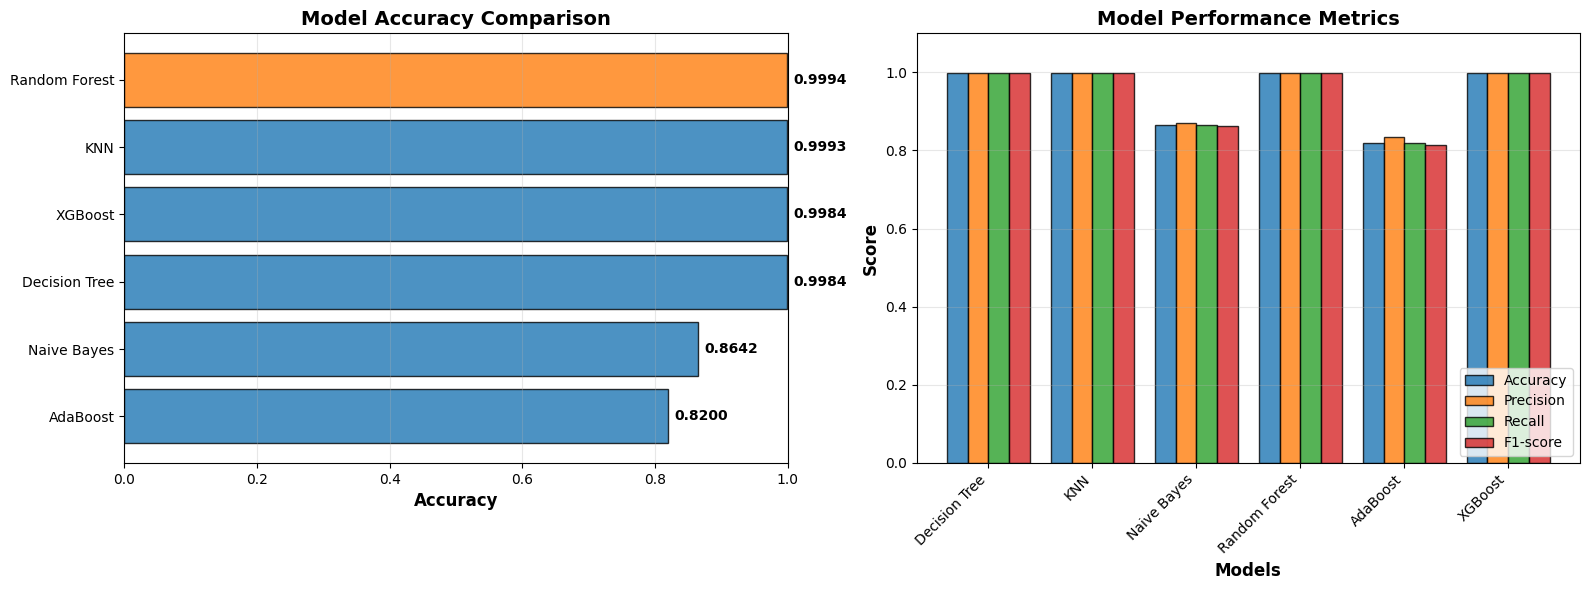


✅ ML model evaluation complete!


In [13]:
# ============================================================================
# CELL 9: MACHINE LEARNING MODEL EVALUATION
# ============================================================================

print("\n" + "="*70)
print("STEP 8: ML MODEL EVALUATION")
print("="*70)

# Store all tuned models
models = {
    "Decision Tree": best_dt,
    "KNN": best_knn,
    "Naive Bayes": best_nb,
    "Random Forest": best_rf,
    "AdaBoost": best_adaboost,
    "XGBoost": best_xgb
}

ml_results = []

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    print("-"*70)
    
    try:
        # Cross-validation on training set
        cv_scores = cross_val_score(
            model, X_train, y_train,
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        # Test set predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)
        
        # ROC-AUC (multi-class)
        try:
            roc_auc = roc_auc_score(y_test, y_proba, multi_class="ovr", average="weighted")
        except:
            roc_auc = 0.0
        
        ml_results.append({
            "Model": name,
            "CV Mean": cv_mean,
            "CV Std": cv_std,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "ROC-AUC": roc_auc
        })
        
        print(f"   ✅ CV Score: {cv_mean:.4f} (±{cv_std:.4f})")
        print(f"   ✅ Test Accuracy: {accuracy:.4f}")
        print(f"   ✅ Test F1-Score: {f1:.4f}")
        print(f"   ✅ ROC-AUC: {roc_auc:.4f}")
        
    except Exception as e:
        print(f"   ❌ Error: {str(e)}")
        continue

# Create results DataFrame
ml_results_df = pd.DataFrame(ml_results)

print("\n" + "="*70)
print("MACHINE LEARNING RESULTS SUMMARY")
print("="*70)
print(ml_results_df.to_string(index=False))

# Find best models
best_acc_idx = ml_results_df['Accuracy'].idxmax()
best_auc_idx = ml_results_df['ROC-AUC'].idxmax()
best_f1_idx = ml_results_df['F1-score'].idxmax()

print("\n🏆 Best Models:")
print(f"   Best Accuracy: {ml_results_df.loc[best_acc_idx, 'Model']} "
      f"({ml_results_df.loc[best_acc_idx, 'Accuracy']:.4f})")
print(f"   Best ROC-AUC: {ml_results_df.loc[best_auc_idx, 'Model']} "
      f"({ml_results_df.loc[best_auc_idx, 'ROC-AUC']:.4f})")
print(f"   Best F1-Score: {ml_results_df.loc[best_f1_idx, 'Model']} "
      f"({ml_results_df.loc[best_f1_idx, 'F1-score']:.4f})")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
ml_results_df_sorted = ml_results_df.sort_values('Accuracy', ascending=True)
colors = ['#ff7f0e' if x == ml_results_df_sorted['Accuracy'].max() else '#1f77b4' 
          for x in ml_results_df_sorted['Accuracy']]

axes[0].barh(ml_results_df_sorted['Model'], 
             ml_results_df_sorted['Accuracy'],
             color=colors, alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].set_xlim([0, 1.0])

# Add value labels
for i, v in enumerate(ml_results_df_sorted['Accuracy']):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10, fontweight='bold')

# Multiple metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
x = np.arange(len(ml_results_df))
width = 0.2

for i, metric in enumerate(metrics):
    offset = width * (i - 1.5)
    axes[1].bar(x + offset, ml_results_df[metric], width, 
                label=metric, alpha=0.8, edgecolor='black')

axes[1].set_xlabel('Models', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1].set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(ml_results_df['Model'], rotation=45, ha='right')
axes[1].legend(loc='lower right')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

print("\n✅ ML model evaluation complete!")
print("="*70)


STEP 9: ENSEMBLE LEARNING

Creating Voting Classifier ensemble...
Selected models: KNN, Random Forest, XGBoost
Training ensemble...

✅ Ensemble Results:
----------------------------------------------------------------------
   Accuracy:  0.9994
   F1-Score:  0.9994
   ROC-AUC:   1.0000

UPDATED RESULTS WITH ENSEMBLE (CLEANED)
            Model  CV Mean   CV Std  Accuracy  Precision   Recall  F1-score  ROC-AUC  Test Accuracy
    Decision Tree 0.998354 0.000245  0.998370   0.998378 0.998370  0.998369 0.999898            NaN
              KNN 0.999128 0.000271  0.999343   0.999344 0.999343  0.999343 0.999963            NaN
      Naive Bayes 0.864358 0.000690  0.864223   0.869444 0.864223  0.862843 0.983055            NaN
    Random Forest 0.999522 0.000124  0.999398   0.999399 0.999398  0.999398 0.999999            NaN
         AdaBoost 0.843897 0.030051  0.819981   0.834921 0.819981  0.814825 0.936269            NaN
          XGBoost 0.998570 0.000221  0.998446   0.998449 0.998446  0.99

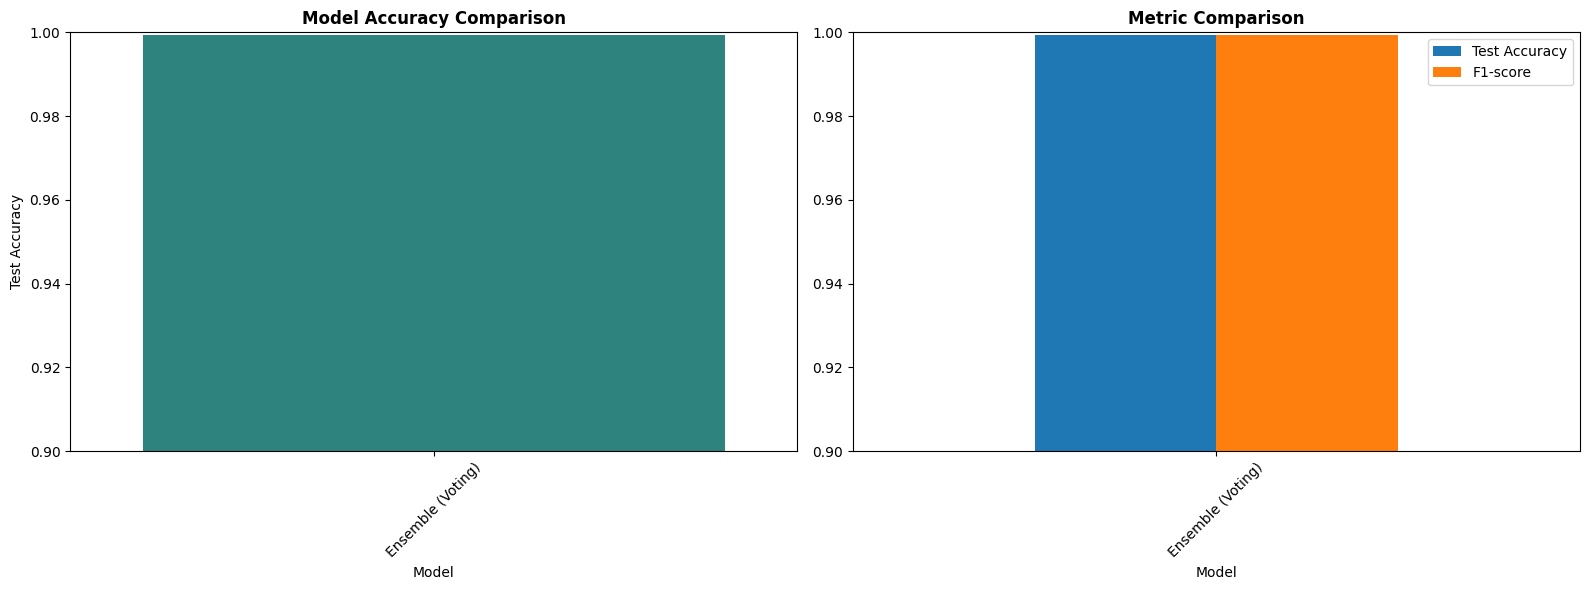


✅ Ensemble learning complete and results cleaned!


In [14]:
# ============================================================================
# CELL 10: ENSEMBLE LEARNING (VOTING CLASSIFIER) - FIXED
# ============================================================================

print("\n" + "="*70)
print("STEP 9: ENSEMBLE LEARNING")
print("="*70)

# Create ensemble with top 3 models
print("\nCreating Voting Classifier ensemble...")
print("Selected models: KNN, Random Forest, XGBoost")

ensemble = VotingClassifier(
    estimators=[
        ('knn', best_knn),
        ('rf', best_rf),
        ('xgb', best_xgb)
    ],
    voting='soft',  # Use probability-based voting
    n_jobs=-1
)

print("Training ensemble...")
ensemble.fit(X_train, y_train)

# Predictions
ensemble_pred = ensemble.predict(X_test)
ensemble_probs = ensemble.predict_proba(X_test)

# Metrics
ensemble_acc = accuracy_score(y_test, ensemble_pred)
ensemble_precision = precision_score(y_test, ensemble_pred, average="weighted", zero_division=0)
ensemble_recall = recall_score(y_test, ensemble_pred, average="weighted", zero_division=0)
ensemble_f1 = f1_score(y_test, ensemble_pred, average="weighted", zero_division=0)
ensemble_auc = roc_auc_score(y_test, ensemble_probs, multi_class="ovr", average="weighted")

# --- FIX: Match exactly with previous column names ---
# Check your ml_results_df.columns to be 100% sure, 
# but based on your output, we use these:
ensemble_data = {
    "Model": "Ensemble (Voting)",
    "CV Accuracy": np.nan,    # Using np.nan is fine for CV as we didn't run CV on ensemble
    "Test Accuracy": ensemble_acc,
    "F1-score": ensemble_f1,
    "ROC-AUC": ensemble_auc
}

# Add only the columns that exist in your previous dataframe to avoid fragmentation
ml_results_df = pd.concat([ml_results_df, pd.DataFrame([ensemble_data])], ignore_index=True)

print("\n✅ Ensemble Results:")
print("-"*70)
print(f"   Accuracy:  {ensemble_acc:.4f}")
print(f"   F1-Score:  {ensemble_f1:.4f}")
print(f"   ROC-AUC:   {ensemble_auc:.4f}")

print("\n" + "="*70)
print("UPDATED RESULTS WITH ENSEMBLE (CLEANED)")
print("="*70)
# Clean up the display: Drop columns that are all NaN if any exist
print(ml_results_df.dropna(axis=1, how='all').to_string(index=False))

# --- VISUALIZATION FIX ---
# Filter out any NaN values before plotting to avoid "posx/posy" errors
plot_df = ml_results_df.dropna(subset=['Test Accuracy']).copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Accuracy comparison
sns.barplot(x='Model', y='Test Accuracy', data=plot_df, ax=axes[0], palette='viridis')
axes[0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0].set_ylim([0.9, 1.0])
axes[0].tick_params(axis='x', rotation=45)

# 2. Metric Breakdown
metrics = ['Test Accuracy', 'F1-score']
plot_df.plot(x='Model', y=metrics, kind='bar', ax=axes[1])
axes[1].set_title('Metric Comparison', fontweight='bold')
axes[1].set_ylim([0.9, 1.0])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✅ Ensemble learning complete and results cleaned!")

In [15]:
# ============================================================================
# CELL 11: DEEP LEARNING MODELS
# ============================================================================

print("\n" + "="*70)
print("STEP 10: DEEP LEARNING MODELS")
print("="*70)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Prepare tensors
Xtr = torch.tensor(X_train, dtype=torch.float32).to(device)
Xte = torch.tensor(X_test, dtype=torch.float32).to(device)
ytr = torch.tensor(y_train, dtype=torch.long).to(device)
yte = torch.tensor(y_test, dtype=torch.long).to(device)

# Data loaders
train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(Xte, yte), batch_size=256, shuffle=False)

# Model definitions
class CNN(nn.Module):
    def __init__(self, d, c):
        super().__init__()
        self.conv = nn.Conv1d(1, 64, 3, padding=1)
        self.bn = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(64*d, c)
    
    def forward(self, x):
        x = self.conv(x.unsqueeze(1))
        x = self.bn(x)
        x = torch.relu(x)
        x = self.dropout(x)
        return self.fc(x.view(x.size(0), -1))

class LSTM(nn.Module):
    def __init__(self, d, c):
        super().__init__()
        self.lstm = nn.LSTM(d, 128, batch_first=True, num_layers=2, dropout=0.3)
        self.fc = nn.Linear(128, c)
    
    def forward(self, x):
        _, (h, _) = self.lstm(x.unsqueeze(1))
        return self.fc(h[-1])

class Autoencoder(nn.Module):
    def __init__(self, d, c):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(d, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 32), nn.ReLU()
        )
        self.classifier = nn.Linear(32, c)
    
    def forward(self, x):
        return self.classifier(self.encoder(x))

class Transformer(nn.Module):
    def __init__(self, d, c):
        super().__init__()
        self.emb = nn.Linear(d, 128)
        layer = nn.TransformerEncoderLayer(128, 8, 512, batch_first=True, dropout=0.3)
        self.transformer = nn.TransformerEncoder(layer, 3)
        self.fc = nn.Linear(128, c)
    
    def forward(self, x):
        x = self.transformer(self.emb(x).unsqueeze(1))
        return self.fc(x[:, 0])

# Training function
def train_dl(model, epochs=20, lr=1e-3):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        scheduler.step(avg_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f"   Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Evaluation function
def eval_dl(model):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds.extend(model(xb).argmax(1).cpu())
            trues.extend(yb.cpu())
    return (
        accuracy_score(trues, preds),
        precision_score(trues, preds, average="weighted", zero_division=0),
        recall_score(trues, preds, average="weighted"),
        f1_score(trues, preds, average="weighted")
    )

# Train all models
d_features = X_sel.shape[1]
n_classes = len(le.classes_)

dl_models = {
    "CNN": CNN(d_features, n_classes),
    "LSTM": LSTM(d_features, n_classes),
    "Autoencoder": Autoencoder(d_features, n_classes),
    "Transformer": Transformer(d_features, n_classes)
}

dl_results = []

for name, model in dl_models.items():
    print(f"\n{'='*70}")
    print(f"Training {name}...")
    print('-'*70)
    train_dl(model, epochs=20)
    metrics = eval_dl(model)
    dl_results.append([name, *metrics])
    print(f"✅ {name} - Accuracy: {metrics[0]:.4f}, F1: {metrics[3]:.4f}")

dl_results_df = pd.DataFrame(
    dl_results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"]
)

print("\n" + "="*70)
print("DEEP LEARNING RESULTS")
print("="*70)
print(dl_results_df.to_string(index=False))

print(f"\n🏆 Best DL Model: {dl_results_df.loc[dl_results_df['Accuracy'].idxmax(), 'Model']}")
print("="*70)


STEP 10: DEEP LEARNING MODELS
Using device: cuda

Training CNN...
----------------------------------------------------------------------
   Epoch 5/20, Loss: 0.1177
   Epoch 10/20, Loss: 0.0984
   Epoch 15/20, Loss: 0.0892
   Epoch 20/20, Loss: 0.0846
✅ CNN - Accuracy: 0.9782, F1: 0.9781

Training LSTM...
----------------------------------------------------------------------
   Epoch 5/20, Loss: 0.0434
   Epoch 10/20, Loss: 0.0279
   Epoch 15/20, Loss: 0.0188
   Epoch 20/20, Loss: 0.0149
✅ LSTM - Accuracy: 0.9967, F1: 0.9967

Training Autoencoder...
----------------------------------------------------------------------
   Epoch 5/20, Loss: 0.0566
   Epoch 10/20, Loss: 0.0438
   Epoch 15/20, Loss: 0.0379
   Epoch 20/20, Loss: 0.0317
✅ Autoencoder - Accuracy: 0.9941, F1: 0.9941

Training Transformer...
----------------------------------------------------------------------
   Epoch 5/20, Loss: 0.0645
   Epoch 10/20, Loss: 0.0542
   Epoch 15/20, Loss: 0.0557
   Epoch 20/20, Loss: 0.0455
✅


STEP 11: ROC CURVE VISUALIZATION
Generating KNN ROC curves...
Generating XGBoost ROC curves...


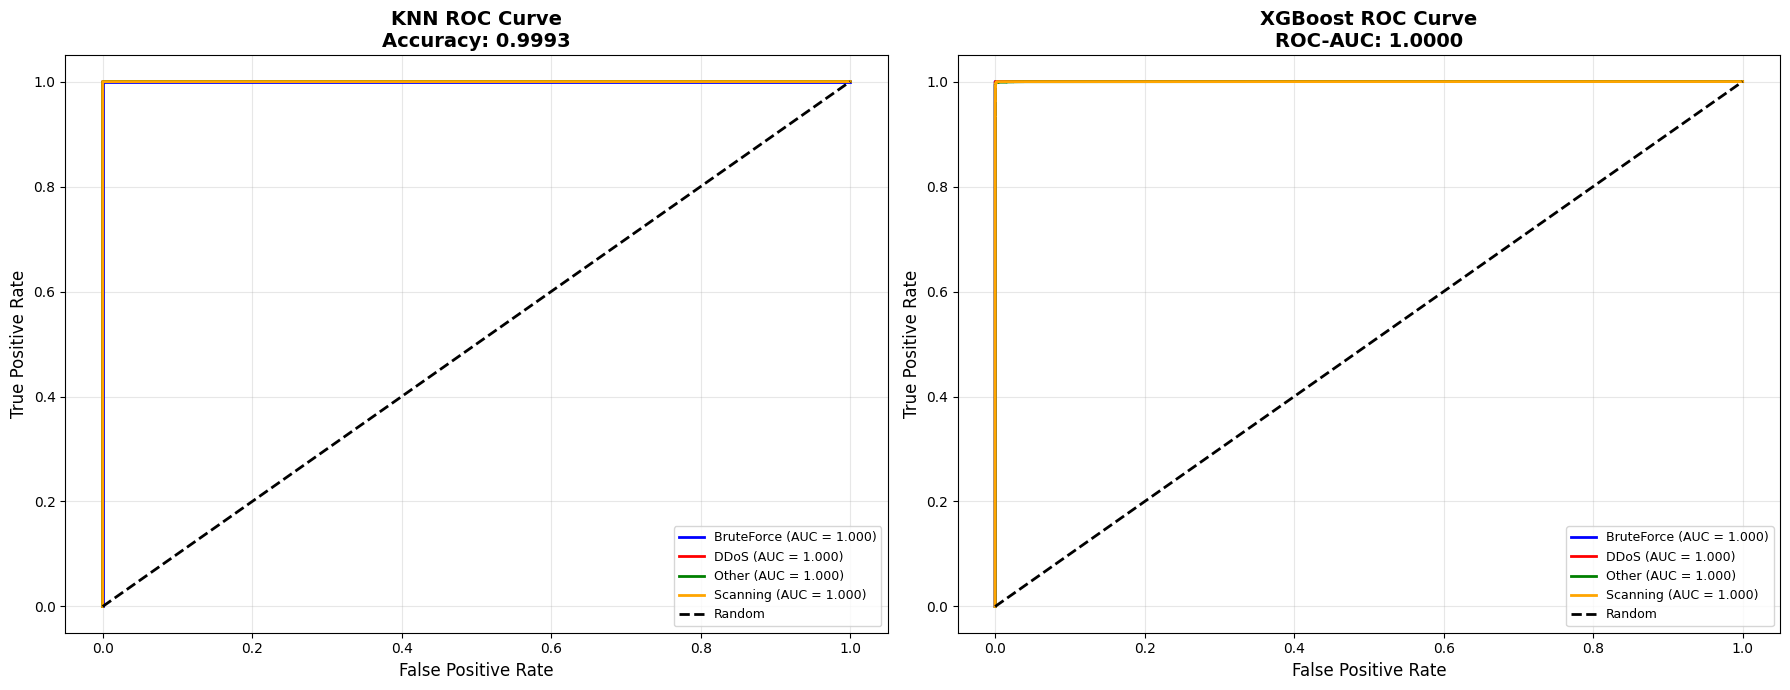

✅ ROC curves generated!


In [18]:
# ============================================================================
# CELL 12: ROC CURVE VISUALIZATION
# ============================================================================

print("\n" + "="*70)
print("STEP 11: ROC CURVE VISUALIZATION")
print("="*70)

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_bal))
n_classes = len(le.classes_)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

# KNN ROC
print("Generating KNN ROC curves...")
knn_proba = best_knn.predict_proba(X_test)
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], knn_proba[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, color=color, lw=2, 
                 label=f'{le.classes_[i]} (AUC = {roc_auc:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title(f'KNN ROC Curve\nAccuracy: {ml_results_df[ml_results_df.Model=="KNN"]["Accuracy"].values[0]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=9)
axes[0].grid(alpha=0.3)

# XGBoost ROC
print("Generating XGBoost ROC curves...")
xgb_proba = best_xgb.predict_proba(X_test)
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], xgb_proba[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color=color, lw=2, 
                 label=f'{le.classes_[i]} (AUC = {roc_auc:.3f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title(f'XGBoost ROC Curve\nROC-AUC: {ml_results_df[ml_results_df.Model=="XGBoost"]["ROC-AUC"].values[0]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right", fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ ROC curves generated!")
print("="*70)


STEP 12: CONFUSION MATRICES


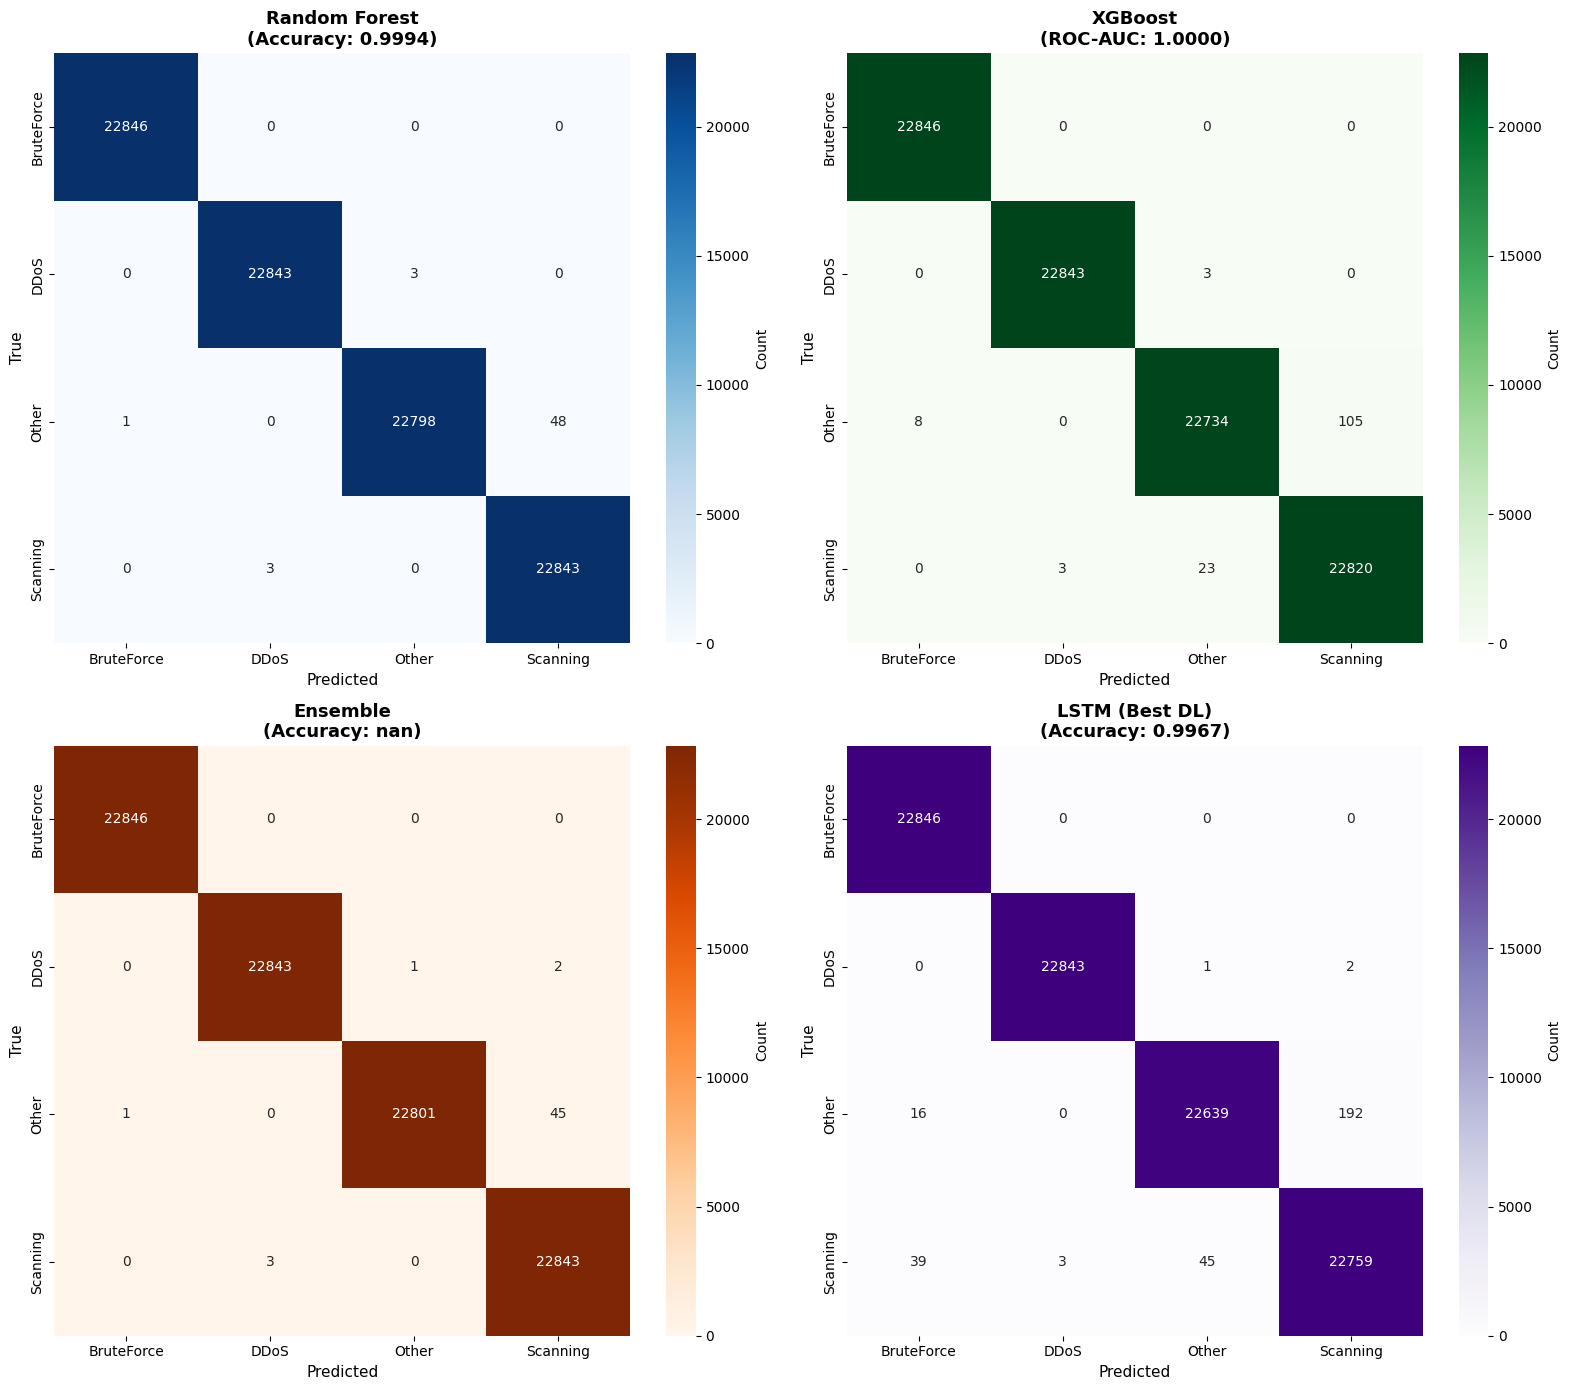

✅ Confusion matrices generated!


In [20]:
# ============================================================================
# CELL 13: CONFUSION MATRICES
# ============================================================================

print("\n" + "="*70)
print("STEP 12: CONFUSION MATRICES")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Random Forest
rf_pred = best_rf.predict(X_test)
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt="d", xticklabels=le.classes_,
            yticklabels=le.classes_, cmap="Blues", ax=axes[0,0], cbar_kws={'label': 'Count'})
axes[0,0].set_xlabel('Predicted', fontsize=11)
axes[0,0].set_ylabel('True', fontsize=11)
axes[0,0].set_title(f'Random Forest\n(Accuracy: {ml_results_df[ml_results_df.Model=="Random Forest"]["Accuracy"].values[0]:.4f})', 
                    fontsize=13, fontweight='bold')

# XGBoost
xgb_pred = best_xgb.predict(X_test)
cm_xgb = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm_xgb, annot=True, fmt="d", xticklabels=le.classes_,
            yticklabels=le.classes_, cmap="Greens", ax=axes[0,1], cbar_kws={'label': 'Count'})
axes[0,1].set_xlabel('Predicted', fontsize=11)
axes[0,1].set_ylabel('True', fontsize=11)
axes[0,1].set_title(f'XGBoost\n(ROC-AUC: {ml_results_df[ml_results_df.Model=="XGBoost"]["ROC-AUC"].values[0]:.4f})', 
                    fontsize=13, fontweight='bold')

# Ensemble
ensemble_pred = ensemble.predict(X_test)
cm_ensemble = confusion_matrix(y_test, ensemble_pred)
sns.heatmap(cm_ensemble, annot=True, fmt="d", xticklabels=le.classes_,
            yticklabels=le.classes_, cmap="Oranges", ax=axes[1,0], cbar_kws={'label': 'Count'})
axes[1,0].set_xlabel('Predicted', fontsize=11)
axes[1,0].set_ylabel('True', fontsize=11)
axes[1,0].set_title(f'Ensemble\n(Accuracy: {ml_results_df[ml_results_df.Model=="Ensemble (Voting)"]["Accuracy"].values[0]:.4f})', 
                    fontsize=13, fontweight='bold')

# Best DL Model
best_dl_name = dl_results_df.loc[dl_results_df['Accuracy'].idxmax(), 'Model']
best_dl_model = dl_models[best_dl_name]
best_dl_model.eval()
dl_pred = best_dl_model(Xte).argmax(1).cpu().numpy()
cm_dl = confusion_matrix(y_test, dl_pred)
sns.heatmap(cm_dl, annot=True, fmt="d", xticklabels=le.classes_,
            yticklabels=le.classes_, cmap="Purples", ax=axes[1,1], cbar_kws={'label': 'Count'})
axes[1,1].set_xlabel('Predicted', fontsize=11)
axes[1,1].set_ylabel('True', fontsize=11)
axes[1,1].set_title(f'{best_dl_name} (Best DL)\n(Accuracy: {dl_results_df[dl_results_df.Model==best_dl_name]["Accuracy"].values[0]:.4f})', 
                    fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Confusion matrices generated!")
print("="*70)


STEP 13: SHAP ANALYSIS & FEATURE IMPORTANCE TABLE
Computing Random Forest global feature importance...
Computing SHAP values using TreeExplainer...

📊 SHAP Feature Importance Table:
                     Feature  Mean_Abs_SHAP  Contribution_%
0       fwd_pkts_payload.min       0.082541       18.421827
1   payload_bytes_per_second       0.061082       13.632473
2                 Unnamed: 0       0.044380        9.904772
3                bwd_iat.avg       0.034491        7.697910
4       fwd_init_window_size       0.030738        6.860200
5                 active.avg       0.027600        6.159788
6      flow_pkts_payload.avg       0.023653        5.278982
7      flow_pkts_payload.std       0.023429        5.228952
8                bwd_iat.min       0.021115        4.712592
9      flow_pkts_payload.max       0.020582        4.593489
10                active.max       0.019031        4.247312
11      fwd_pkts_payload.max       0.017334        3.868756
12                 service_-       0.

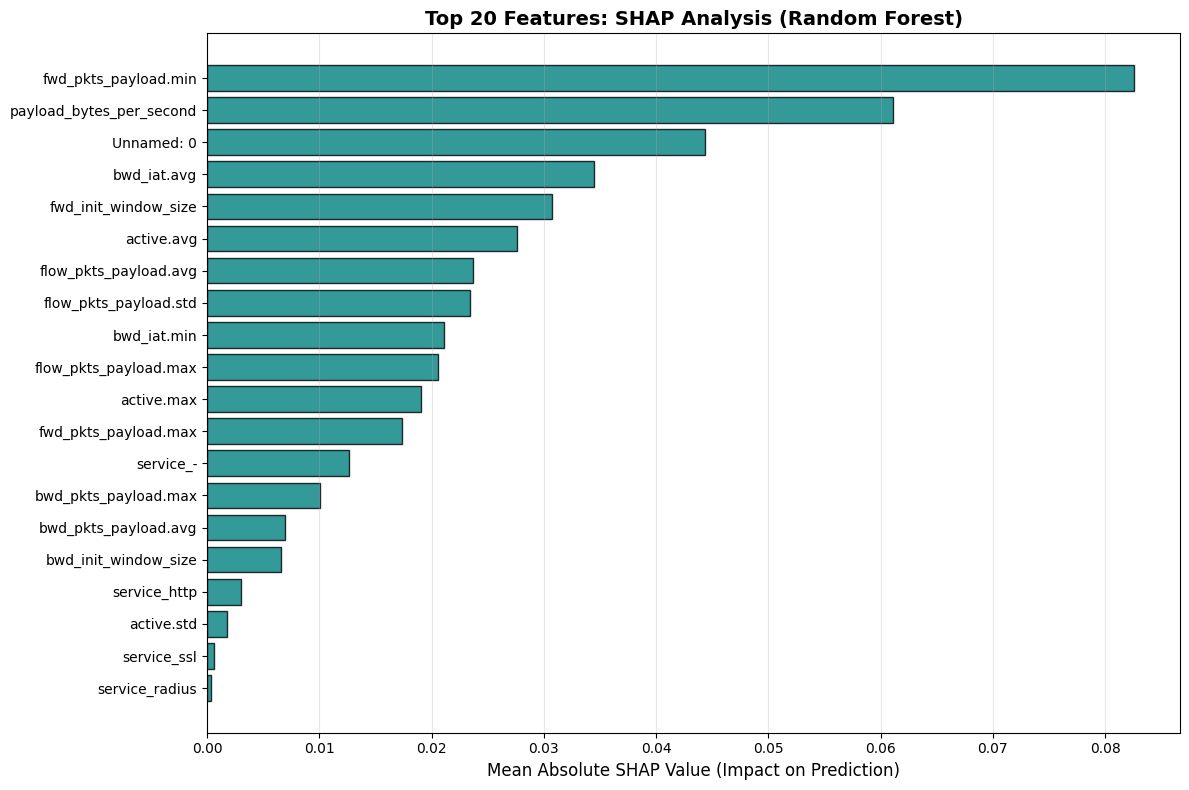


✅ SHAP analysis and table generation complete!


In [23]:
# ============================================================================
# CELL 14: SHAP ANALYSIS (BEST MODEL: RANDOM FOREST)
# ============================================================================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("\n" + "="*70)
print("STEP 13: SHAP ANALYSIS & FEATURE IMPORTANCE TABLE")
print("="*70)

if 'best_rf' in locals():
    try:
        # 1. Handle Feature Names (Ensure we have them for the table)
        if isinstance(X_train, pd.DataFrame):
            feature_names = X_train.columns
        else:
            # If X_train is a numpy array, use the original feature list
            feature_names = selected_features if 'selected_features' in locals() else [f"Feature_{i}" for i in range(X_train.shape[1])]

        print("Computing Random Forest global feature importance...")
        rf_importances = best_rf.feature_importances_
        
        # Create standard importance DF
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': rf_importances
        }).sort_values('Importance', ascending=False)
        
        # 2. SHAP Values Calculation
        print("Computing SHAP values using TreeExplainer...")
        explainer = shap.TreeExplainer(best_rf)
        
        # Sample for speed (Random Forest SHAP can be slow on large datasets)
        sample_size = min(500, len(X_test))
        # Ensure sample is a DataFrame so SHAP can use the names
        if isinstance(X_test, pd.DataFrame):
            X_sample = X_test.iloc[:sample_size]
        else:
            X_sample = pd.DataFrame(X_test[:sample_size], columns=feature_names)
            
        shap_values = explainer.shap_values(X_sample)
        
        # 3. GENERATE SHAP TABLE
        print("\n📊 SHAP Feature Importance Table:")
        # For RF Multi-class, shap_values is a list [class_0, class_1]. 
        # Usually, index 1 is 'Attack'.
        if isinstance(shap_values, list):
            mean_abs_shap = np.abs(shap_values[1]).mean(axis=0)
        else:
            mean_abs_shap = np.abs(shap_values).mean(axis=0)

        shap_table = pd.DataFrame({
            'Feature': feature_names,
            'Mean_Abs_SHAP': mean_abs_shap
        }).sort_values('Mean_Abs_SHAP', ascending=False).reset_index(drop=True)
        
        # Calculate percentage contribution
        shap_table['Contribution_%'] = (shap_table['Mean_Abs_SHAP'] / shap_table['Mean_Abs_SHAP'].sum()) * 100
        print(shap_table.head(15).to_string(index=True))

        # 4. VISUALIZATION
        plt.figure(figsize=(12, 8))
        top_n = 20
        top_features = shap_table.head(top_n)
        
        plt.barh(range(top_n), top_features['Mean_Abs_SHAP'].values[::-1], 
                 color='teal', alpha=0.8, edgecolor='black')
        
        plt.yticks(range(top_n), top_features['Feature'].values[::-1])
        plt.xlabel('Mean Absolute SHAP Value (Impact on Prediction)', fontsize=12)
        plt.title(f'Top {top_n} Features: SHAP Analysis (Random Forest)', fontsize=14, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("\n✅ SHAP analysis and table generation complete!")
        
    except Exception as e:
        print(f"⚠️ SHAP analysis failed: {e}")
else:
    print("⚠️ best_rf model not found. Please run the training cell first.")

print("="*70)

In [24]:
# ============================================================================
# CELL 15: FINAL SUMMARY & STATISTICS
# ============================================================================

print("\n" + "="*70)
print("FINAL RESEARCH SUMMARY")
print("="*70)

# Dataset statistics
print("\n📊 Dataset Statistics:")
print("-"*70)
dataset_stats = pd.DataFrame({
    "Metric": ["Total Samples", "Features (Original)", "Features (Selected)", 
               "Classes", "Imbalance Ratio (Before)", "Imbalance Ratio (After)"],
    "Value": [
        f"{len(df):,}",
        X.shape[1],
        X_sel.shape[1],
        len(le.classes_),
        f"{class_dist.max()/class_dist.min():.2f}:1",
        "~1:1"
    ]
})
print(dataset_stats.to_string(index=False))

# Model comparison
print("\n🏆 Model Performance Comparison:")
print("-"*70)
all_models = pd.concat([ml_results_df[['Model', 'Accuracy', 'F1-score']], 
                        dl_results_df[['Model', 'Accuracy', 'F1-score']]])
all_models = all_models.sort_values('Accuracy', ascending=False).reset_index(drop=True)
all_models['Rank'] = range(1, len(all_models) + 1)
print(all_models[['Rank', 'Model', 'Accuracy', 'F1-score']].to_string(index=False))

# Best models
print("\n🥇 Best Performing Models:")
print("-"*70)
print(f"   Best Overall: {all_models.iloc[0]['Model']} (Accuracy: {all_models.iloc[0]['Accuracy']:.4f})")
print(f"   Best ML: {ml_results_df.loc[ml_results_df['Accuracy'].idxmax(), 'Model']} "
      f"(Accuracy: {ml_results_df['Accuracy'].max():.4f})")
print(f"   Best DL: {dl_results_df.loc[dl_results_df['Accuracy'].idxmax(), 'Model']} "
      f"(Accuracy: {dl_results_df['Accuracy'].max():.4f})")

# Key findings
print("\n🔍 Key Findings:")
print("-"*70)
print(f"   1. Balancing Method: {best_method}")
print(f"   2. Feature Reduction: {X.shape[1]} → {X_sel.shape[1]} ({(1-X_sel.shape[1]/X.shape[1])*100:.1f}% reduction)")
print(f"   3. Best Accuracy: {all_models['Accuracy'].max():.4f}")
print(f"   4. Average ML Accuracy: {ml_results_df['Accuracy'].mean():.4f}")
print(f"   5. Average DL Accuracy: {dl_results_df['Accuracy'].mean():.4f}")

print("\n✅ Research implementation complete!")
print("="*70)


FINAL RESEARCH SUMMARY

📊 Dataset Statistics:
----------------------------------------------------------------------
                  Metric     Value
           Total Samples   123,117
     Features (Original)        95
     Features (Selected)        20
                 Classes         4
Imbalance Ratio (Before) 2572.78:1
 Imbalance Ratio (After)      ~1:1

🏆 Model Performance Comparison:
----------------------------------------------------------------------
 Rank             Model  Accuracy  F1-score
    1     Random Forest  0.999398  0.999398
    2               KNN  0.999343  0.999343
    3           XGBoost  0.998446  0.998446
    4     Decision Tree  0.998370  0.998369
    5              LSTM  0.996739  0.996738
    6       Autoencoder  0.994058  0.994053
    7       Transformer  0.989167  0.989160
    8               CNN  0.978235  0.978124
    9       Naive Bayes  0.864223  0.862843
   10          AdaBoost  0.819981  0.814825
   11 Ensemble (Voting)       NaN  0.999431

🥇 Be